<a href="https://colab.research.google.com/github/Qais-Hweidi/Object-Detection-OpenCV-python/blob/main/Object_Detection_OpenCV_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

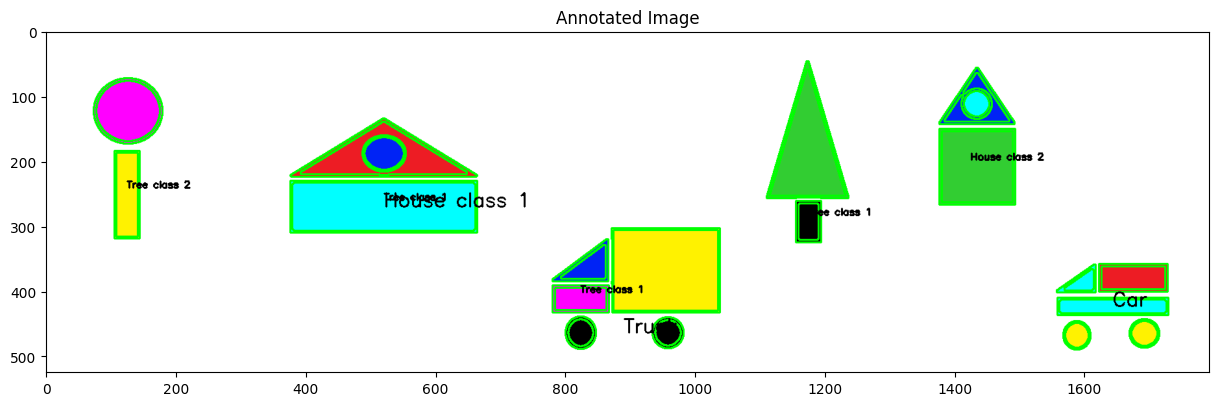

In [ ]:
# Qais Hweidi

# Initialize the set to keep track of used shapes
used_shapes = set()

# Define a function to check if a truck-like structure is detected
def is_truck_detected(shape_details, contours, used_shapes):
    circles = [s for s in shape_details if s[1] == "Circle" and s[0] not in used_shapes]
    rectangles = [s for s in shape_details if s[1] in ["Rectangle", "Square"] and s[0] not in used_shapes]
    triangles = [s for s in shape_details if s[1] == "Triangle" and s[0] not in used_shapes]

    for circle1 in circles:
        c1_idx, c1_shape, c1_color, (c1_x, c1_y), c1_parent = circle1
        for circle2 in circles:
            c2_idx, c2_shape, c2_color, (c2_x, c2_y), c2_parent = circle2
            if c1_idx >= c2_idx:
                continue  # avoid duplicates
            # Check if circles are horizontally aligned and close enough
            if abs(c1_y - c2_y) < 20 and abs(c1_x - c2_x) < 200:
                # Determine which circle is left and which is right
                if c1_x < c2_x:
                    left_circle = circle1
                    right_circle = circle2
                else:
                    left_circle = circle2
                    right_circle = circle1
                # For the left circle, find a rectangle above it
                for rect1 in rectangles:
                    r1_idx, r1_shape, r1_color, (r1_x, r1_y), r1_parent = rect1
                    if abs(r1_x - left_circle[3][0]) < 50 and r1_y < left_circle[3][1]:
                        # Now find a triangle above this rectangle
                        for tri in triangles:
                            t_idx, t_shape, t_color, (t_x, t_y), t_parent = tri
                            if abs(t_x - r1_x) < 50 and t_y < r1_y:
                                # For the right circle, find a rectangle or square above it
                                for rect2 in rectangles:
                                    r2_idx, r2_shape, r2_color, (r2_x, r2_y), r2_parent = rect2
                                    if abs(r2_x - right_circle[3][0]) < 50 and r2_y < right_circle[3][1]:
                                        # Truck detected
                                        used_shapes.update({c1_idx, c2_idx, r1_idx, r2_idx, t_idx})
                                        truck_position = (int((c1_x + c2_x) / 2), int((c1_y + c2_y) / 2))
                                        return True, truck_position
    return False, (0, 0)

# Update the shape_details list to include contour indices
shape_details = []
contour_to_details = {}
for i, c in enumerate(contours):
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    shape = detect_shape(c)
    color = detect_color(image, c)

    if shape != "unidentified":
        parent_index = hierarchy[0][i][3]
        if parent_index != -1:
            parent_shape = detect_shape(contours[parent_index])
            parent_color = detect_color(image, contours[parent_index])
            if shape == "Circle" and shape == parent_shape and color == parent_color:
                continue
            text = f"{shape}, {color} inside {parent_shape}, {parent_color}"
        else:
            text = f"{shape}, {color}"
        shape_details.append((i, shape, color, (cX, cY), parent_index))
        contour_to_details[i] = (shape, color, (cX, cY), parent_index)

        if shape == "Square":
            cv2.putText(contour_image, "House class 2", (cX - 10, cY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# Check if a truck-like structure is detected
truck_detected, truck_position = is_truck_detected(shape_details, contours, used_shapes)

# If a truck is detected, annotate the image
if truck_detected:
    cv2.putText(contour_image, "Truck", truck_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Modify existing detection functions to consider used_shapes
def is_car_detected(shape_details, contours, used_shapes):
    circles = [s for s in shape_details if s[1] == "Circle" and s[0] not in used_shapes]
    rectangles = [s for s in shape_details if s[1] == "Rectangle" and s[0] not in used_shapes]
    for rect in rectangles:
        rect_idx, rect_shape, rect_color, (rect_x, rect_y), rect_parent = rect
        if rect_idx in used_shapes:
            continue
        circle_count = 0
        for circle in circles:
            circle_idx, circle_shape, circle_color, (circle_x, circle_y), circle_parent = circle
            if circle_idx in used_shapes:
                continue
            if abs(circle_y - rect_y) > 20 and abs(circle_y - rect_y) < 100 and abs(circle_x - rect_x) < 100:
                circle_count += 1
                used_shapes.add(circle_idx)
        if circle_count >= 2:
            used_shapes.add(rect_idx)
            return True, (rect_x, rect_y)
    return False, (0, 0)

# Check if a car-like structure is detected
car_detected, car_position = is_car_detected(shape_details, contours, used_shapes)

# If a car is detected, annotate the image
if car_detected:
    cv2.putText(contour_image, "Car", car_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Adjust Tree class 1 detection
triangles = [s for s in shape_details if s[1] == "Triangle" and s[0] not in used_shapes]
rectangles = [s for s in shape_details if s[1] == "Rectangle" and s[0] not in used_shapes]
for triangle in triangles:
    t_idx, t_shape, t_color, (t_x, t_y), t_parent = triangle
    _, _, triangle_w, _ = cv2.boundingRect(contours[t_idx])
    for rect in rectangles:
        r_idx, r_shape, r_color, (r_x, r_y), r_parent = rect
        if r_idx in used_shapes:
            continue
        _, _, rect_w, _ = cv2.boundingRect(contours[r_idx])
        if r_y > t_y and r_x > t_x - rect_w // 2 and r_x < t_x + rect_w // 2 and rect_w < triangle_w:
            cv2.putText(contour_image, "Tree class 1", (r_x, r_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            used_shapes.update({t_idx, r_idx})

# Adjust Tree class 2 detection
circles = [s for s in shape_details if s[1] == "Circle" and s[0] not in used_shapes]
rectangles = [s for s in shape_details if s[1] == "Rectangle" and s[0] not in used_shapes]
for circle in circles:
    c_idx, c_shape, c_color, (c_x, c_y), c_parent = circle
    _, _, circle_w, _ = cv2.boundingRect(contours[c_idx])
    for rect in rectangles:
        r_idx, r_shape, r_color, (r_x, r_y), r_parent = rect
        if r_idx in used_shapes:
            continue
        _, _, rect_w, _ = cv2.boundingRect(contours[r_idx])
        if r_y > c_y and r_x > c_x - rect_w // 2 and r_x < c_x + rect_w // 2 and rect_w < circle_w:
            cv2.putText(contour_image, "Tree class 2", (r_x, r_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            used_shapes.update({c_idx, r_idx})

# Adjust House class 1 detection
def is_house_class_1(shape_details, contours, used_shapes):
    rectangles = [s for s in shape_details if s[1] == "Rectangle" and s[0] not in used_shapes]
    triangles = [s for s in shape_details if s[1] == "Triangle" and s[0] not in used_shapes]
    circles = [s for s in shape_details if s[1] == "Circle" and s[0] not in used_shapes]

    for rect in rectangles:
        rect_idx, rect_shape, rect_color, (rect_x, rect_y), rect_parent = rect
        for tri in triangles:
            tri_idx, tri_shape, tri_color, (tri_x, tri_y), tri_parent = tri
            if tri_y < rect_y and abs(tri_x - rect_x) < 50:
                for circ in circles:
                    circ_idx, circ_shape, circ_color, (circ_x, circ_y), circ_parent = circ
                    if circ_y < tri_y and abs(circ_x - tri_x) < 50:
                        used_shapes.update({rect_idx, tri_idx, circ_idx})
                        return True, (rect_x, rect_y)
    return False, (0, 0)

# Check if a House class 1 structure is detected
house_class_1_detected, house_class_1_position = is_house_class_1(shape_details, contours, used_shapes)

# If a House class 1 is detected, annotate the image
if house_class_1_detected:
    cv2.putText(contour_image, "House class 1", house_class_1_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Visualize the result
plt.figure(figsize=(15, 15))
plt.title('Annotated Image')
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()
